In [11]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)

In [12]:
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')

In [13]:
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=50,wait_patient=3, debug=False, tracker='tracker.xlsx', comment=''):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, lr_rate=lr_rate, wait_patient=wait_patient, optimizer=optimizer)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)
    loss = oset.losses[len(oset.losses)-1].numpy()
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [octrain_epochs], 'wait_patient': [wait_patient], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'comment': comment}
    update_tracker(tracker, tracker_data)
    return test_data, oset

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/3
62/62 [==============================] - 7s 99ms/step - loss: 1.1837 - accuracy: 0.5585 - precision: 0.9676 - recall: 0.2858 - val_loss: 1.0390 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.3839
Epoch 2/3
62/62 [==============================] - 6s 94ms/step - loss: 0.6789 - accuracy: 0.7505 - precision: 0.9445 - recall: 0.6008 - val_loss: 0.5300 - val_accuracy: 0.8527 - val_precision: 0.9563 - val_recall: 0.7812
Epoch 3/3
62/62 [==============================] - 6s 95ms/step - loss: 0.4606 - accuracy: 0.8735 - precision: 0.9428 - recall: 0.7555 - 

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.25it/s]


epoch: 1/50, train_loss: 4.979928970336914, F1_train: 0.6600441866917959 F1_val: 0.3710705476411662


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.41it/s]


epoch: 2/50, train_loss: 4.99911642074585, F1_train: 0.7510742814693177 F1_val: 0.4375670490262899


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.50it/s]


epoch: 3/50, train_loss: 4.987513065338135, F1_train: 0.783946301159254 F1_val: 0.4890246634946887


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.43it/s]


epoch: 4/50, train_loss: 4.979439735412598, F1_train: 0.8495847694467024 F1_val: 0.707304028812192


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.10it/s]


epoch: 5/50, train_loss: 4.997683048248291, F1_train: 0.8613335911581231 F1_val: 0.77454438200846


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.46it/s]


epoch: 6/50, train_loss: 5.002133369445801, F1_train: 0.8726804801564833 F1_val: 0.8297717520544493


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.25it/s]


epoch: 7/50, train_loss: 4.9873738288879395, F1_train: 0.8824323719925429 F1_val: 0.8443720032604526


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.47it/s]


epoch: 8/50, train_loss: 5.002580165863037, F1_train: 0.892902033313121 F1_val: 0.8775314338155391


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.37it/s]


epoch: 9/50, train_loss: 4.993923187255859, F1_train: 0.9019593657173393 F1_val: 0.8829036945224704


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.94it/s]


epoch: 10/50, train_loss: 5.001940727233887, F1_train: 0.909141604325166 F1_val: 0.8812044294127317


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.37it/s]


epoch: 11/50, train_loss: 4.998648166656494, F1_train: 0.9124877825866807 F1_val: 0.9047725115425311


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.27it/s]


epoch: 12/50, train_loss: 5.0032806396484375, F1_train: 0.9126447411181089 F1_val: 0.8927744935380453


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.27it/s]


epoch: 13/50, train_loss: 4.994077682495117, F1_train: 0.9126008665446622 F1_val: 0.9048771439977085


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.11it/s]


epoch: 14/50, train_loss: 5.006041049957275, F1_train: 0.9131055882153579 F1_val: 0.8929462213980638


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.36it/s]


epoch: 15/50, train_loss: 4.997560501098633, F1_train: 0.9128321261475457 F1_val: 0.8972984231190532


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.40it/s]


epoch: 16/50, train_loss: 4.998600006103516, F1_train: 0.9118273717090135 F1_val: 0.9053588313394096


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.40it/s]


epoch: 17/50, train_loss: 5.000631332397461, F1_train: 0.9123926481121895 F1_val: 0.921913542603287


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.41it/s]


epoch: 18/50, train_loss: 4.9882049560546875, F1_train: 0.9125984222659843 F1_val: 0.9010259377797719


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 19/50, train_loss: 4.986266613006592, F1_train: 0.9135980251159308 F1_val: 0.8967487550982722


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.43it/s]


epoch: 20/50, train_loss: 4.993237018585205, F1_train: 0.9126333532922208 F1_val: 0.9052046361144317


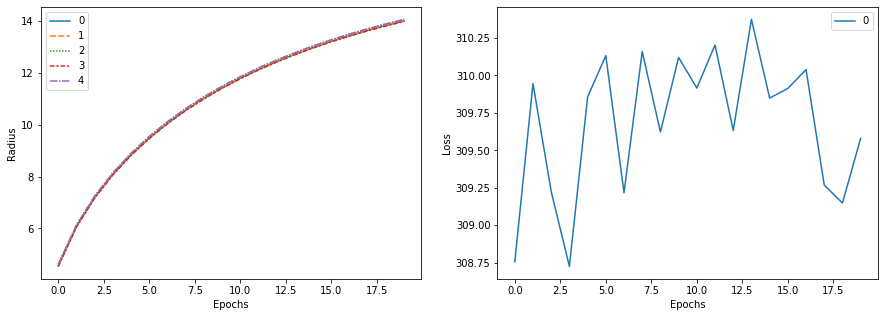

[[28  0  0  0 19  0]
 [ 0 46  0  0  3  0]
 [ 0  0 46  0  0  0]
 [ 0  0  0 41  5  0]
 [ 0  0  0  1 49  0]
 [ 0 19  0 18 13  0]]
72.92
f1_weighted: 0.6648399208471686, f1_macro: 0.6720508479016192, f1_micro: 0.7291666666666665, f_measure: {'Known': 80.6461, 'Open': 0, 'F1-score': 67.2051}
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        47
           1       0.71      0.94      0.81        49
           2       1.00      1.00      1.00        46
           3       0.68      0.89      0.77        46
           4       0.55      0.98      0.71        50
           5       0.00      0.00      0.00        50

    accuracy                           0.73       288
   macro avg       0.66      0.73      0.67       288
weighted avg       0.65      0.73      0.66       288

Empty DataFrame
Columns: []
Index: []
   ablation  designated_ukc_cls  num_classes  embedding_size  lr_rate  \
0       500                   5            5              

In [4]:
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=2,lr_rate=5,optimizer='adam',
pretrain_epochs=3,octrain_epochs=50, wait_patient=3)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 5 is added as ukc
ukc_5:, 100
vocab_size: 50
Epoch 1/14
100/100 [==============================] - 10s 99ms/step - loss: 1.0953 - accuracy: 0.4688 - precision_9: 0.7907 - recall_9: 0.1972 - val_loss: 0.9625 - val_accuracy: 0.5000 - val_precision_9: 0.5588 - val_recall_9: 0.2474
Epoch 2/14
100/100 [==============================] - 10s 96ms/step - loss: 0.9330 - accuracy: 0.5206 - precision_9: 0.6882 - recall_9: 0.2497 - val_loss: 0.8779 - val_accuracy: 0.5026 - val_precision_9: 0.5249 - val_recall_9: 0.2474
Epoch 3/14
100/100 [==============================] - 10s 96ms/step - loss: 0.8765 - accuracy: 0.5734 - precision_9: 0.6923 - recall_9: 0.2503 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.03it/s]


epoch: 1/50, train_loss: 14.165757179260254, F1_train: 0.6506973006195037 F1_val: 0.6461482894128525


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.95it/s]


epoch: 2/50, train_loss: 14.165838241577148, F1_train: 0.6845189612292593 F1_val: 0.6677181149938424


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.05it/s]


epoch: 3/50, train_loss: 14.166088104248047, F1_train: 0.6972673793670936 F1_val: 0.6860531224137092


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.04it/s]


epoch: 4/50, train_loss: 14.165762901306152, F1_train: 0.7024272888375179 F1_val: 0.6727174370516762


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.03it/s]


epoch: 5/50, train_loss: 14.165938377380371, F1_train: 0.7046763751569355 F1_val: 0.6877214237967916


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.04it/s]


epoch: 6/50, train_loss: 14.16569709777832, F1_train: 0.7047152617483202 F1_val: 0.68092703941347


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.03it/s]


epoch: 7/50, train_loss: 14.165853500366211, F1_train: 0.7046779003072088 F1_val: 0.6827008753336473


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.05it/s]


epoch: 8/50, train_loss: 14.166082382202148, F1_train: 0.7050262176595103 F1_val: 0.6819340982173719


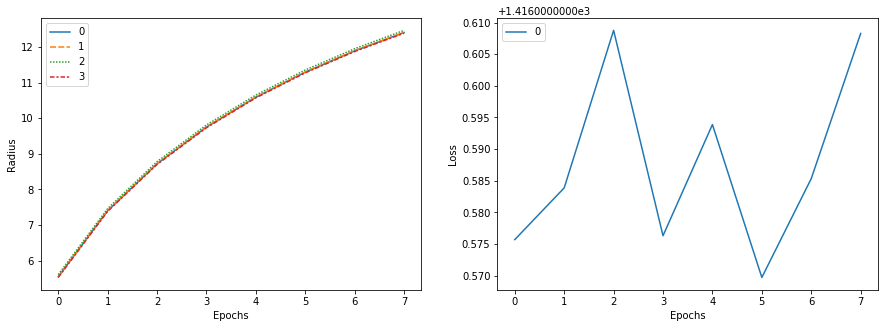

[[98  0  0  0  0]
 [ 0  0  0  0 92]
 [ 0  0 97  0  0]
 [ 0  0  0  2  0]
 [22  0 23  0 50]]
64.32
f1_weighted: 0.5648785779635153, f1_macro: 0.6430065427334487, f1_micro: 0.6432291666666666, f_measure: {'Known': 69.8273, 'Open': 42.1941, 'F1-score': 64.3007}
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        98
           1       0.00      0.00      0.00        92
           2       0.81      1.00      0.89        97
           3       1.00      1.00      1.00         2
           5       0.35      0.53      0.42        95

    accuracy                           0.64       384
   macro avg       0.60      0.71      0.64       384
weighted avg       0.50      0.64      0.56       384

   Unnamed: 0  ablation  designated_ukc_cls  num_classes  embedding_size  \
0           0       500                   5            5               2   

   lr_rate optimizer  pretrain_epochs  octrain_epochs  wait_patient  \
0        5      adam         

In [18]:
test_data, oset = oset_train(ablation=1000,designated_ukc_cls=5,num_classes=4,embedding_size=2,
                             lr_rate=5, optimizer='adam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=3)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 107ms/step - loss: 1.1837 - accuracy: 0.5585 - precision_10: 0.9676 - recall_10: 0.2858 - val_loss: 1.0390 - val_accuracy: 0.6250 - val_precision_10: 1.0000 - val_recall_10: 0.3839
Epoch 2/14
62/62 [==============================] - 6s 103ms/step - loss: 0.6789 - accuracy: 0.7505 - precision_10: 0.9445 - recall_10: 0.6008 - val_loss: 0.5300 - val_accuracy: 0.8527 - val_precision_10: 0.9563 - val_recall_10: 0.7812
Epoch 3/14
62/62 [==============================] - 7s 112ms/step - loss: 0.4606 - accuracy: 0.8735 - precisi

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.28it/s]


epoch: 1/50, train_loss: 15.401331901550293, F1_train: 0.34525693111079336 F1_val: 0.08085794413919413


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.84it/s]


epoch: 2/50, train_loss: 15.378965377807617, F1_train: 0.413298743869324 F1_val: 0.1378815628815629


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.87it/s]


epoch: 3/50, train_loss: 15.374783515930176, F1_train: 0.4599692558488176 F1_val: 0.25305624081134287


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.81it/s]


epoch: 4/50, train_loss: 15.373117446899414, F1_train: 0.4976024701614772 F1_val: 0.3158653415704181


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.58it/s]


epoch: 5/50, train_loss: 15.411981582641602, F1_train: 0.5272745262064114 F1_val: 0.3464331824279007


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.98it/s]


epoch: 6/50, train_loss: 15.366006851196289, F1_train: 0.5609328757381109 F1_val: 0.3510971924418441


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 7/50, train_loss: 15.368725776672363, F1_train: 0.5742910393642954 F1_val: 0.3972771400226757


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.97it/s]


epoch: 8/50, train_loss: 15.362293243408203, F1_train: 0.5950607498996457 F1_val: 0.4321449944993579


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.99it/s]


epoch: 9/50, train_loss: 15.384124755859375, F1_train: 0.6187992933790537 F1_val: 0.474614701871532


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.00it/s]


epoch: 10/50, train_loss: 15.370051383972168, F1_train: 0.6287021353101101 F1_val: 0.4858927779290892


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 11/50, train_loss: 15.4132719039917, F1_train: 0.6414505831256438 F1_val: 0.4868243639767164


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.43it/s]


epoch: 12/50, train_loss: 15.261612892150879, F1_train: 0.6535724973225102 F1_val: 0.5028438011302172


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.90it/s]


epoch: 13/50, train_loss: 15.36155891418457, F1_train: 0.6608966139088209 F1_val: 0.49917868589743586


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.85it/s]


epoch: 14/50, train_loss: 15.333009719848633, F1_train: 0.6677749504774275 F1_val: 0.5007179845962495


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.66it/s]


epoch: 15/50, train_loss: 15.40660285949707, F1_train: 0.6711532009379536 F1_val: 0.4950375939849624


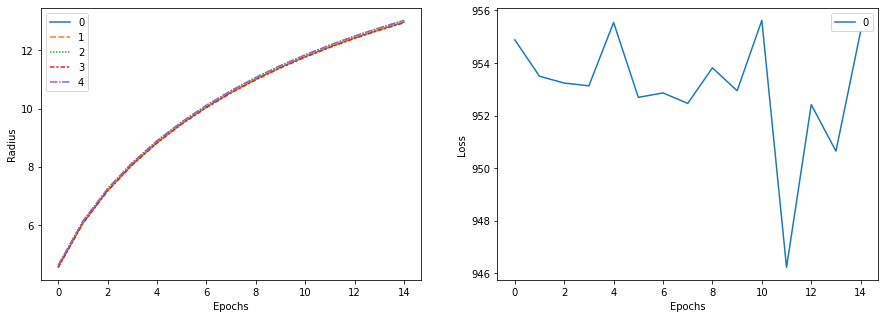

[[26  0  0  0  0 21]
 [ 0 46  0  0  0  3]
 [ 0  0  1  0  0 45]
 [ 0  0  0  5  0 41]
 [ 0  0  0  0 38 12]
 [ 0  2  0  0  0 48]]
56.94
f1_weighted: 0.541426158022799, f1_macro: 0.5332356663721035, f1_micro: 0.5694444444444444, f_measure: {'Known': 55.261, 'Open': 43.6364, 'F1-score': 53.3236}
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        47
           1       0.96      0.94      0.95        49
           2       1.00      0.02      0.04        46
           3       1.00      0.11      0.20        46
           4       1.00      0.76      0.86        50
           5       0.28      0.96      0.44        50

    accuracy                           0.57       288
   macro avg       0.87      0.56      0.53       288
weighted avg       0.87      0.57      0.54       288



In [24]:
comment="make the pre-trained model better"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=2,lr_rate=5,optimizer='adam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=3, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 103ms/step - loss: 1.2459 - accuracy: 0.5186 - precision: 0.9662 - recall: 0.2450 - val_loss: 1.0478 - val_accuracy: 0.7411 - val_precision: 1.0000 - val_recall: 0.3884
Epoch 2/14
62/62 [==============================] - 6s 100ms/step - loss: 0.7508 - accuracy: 0.7021 - precision: 0.9371 - recall: 0.5706 - val_loss: 0.6129 - val_accuracy: 0.7634 - val_precision: 0.9937 - val_recall: 0.7098
Epoch 3/14
62/62 [==============================] - 6s 97ms/step - loss: 0.4726 - accuracy: 0.7692 - precision: 0.9276 - recall: 0.73

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.37it/s]


epoch: 1/50, train_loss: 18.151351928710938, F1_train: 0.08871456684227033 F1_val: 0.09757763975155277


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.60it/s]


epoch: 2/50, train_loss: 18.138113021850586, F1_train: 0.13061567624531095 F1_val: 0.15937668463611862


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.59it/s]


epoch: 3/50, train_loss: 18.15184211730957, F1_train: 0.16142907873377477 F1_val: 0.22586163836163836


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.63it/s]


epoch: 4/50, train_loss: 18.153200149536133, F1_train: 0.29898464601394537 F1_val: 0.284407412092082


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.36it/s]


epoch: 5/50, train_loss: 18.171104431152344, F1_train: 0.3193646796447205 F1_val: 0.299965798208115


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.49it/s]


epoch: 6/50, train_loss: 18.120651245117188, F1_train: 0.35246361412990856 F1_val: 0.3003810313511806


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.57it/s]


epoch: 7/50, train_loss: 18.14455223083496, F1_train: 0.38049123448800387 F1_val: 0.3236661347394713


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.52it/s]


epoch: 8/50, train_loss: 18.111858367919922, F1_train: 0.4066804435126452 F1_val: 0.36386865601503754


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.50it/s]


epoch: 9/50, train_loss: 18.151241302490234, F1_train: 0.4324249639964511 F1_val: 0.3914322226065567


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.60it/s]


epoch: 10/50, train_loss: 18.149948120117188, F1_train: 0.4505658814318466 F1_val: 0.4091544881676848


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.60it/s]


epoch: 11/50, train_loss: 18.15192985534668, F1_train: 0.4757267893287854 F1_val: 0.42065945614082256


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.60it/s]


epoch: 12/50, train_loss: 18.024578094482422, F1_train: 0.4977509907326265 F1_val: 0.4242910102637546


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.59it/s]


epoch: 13/50, train_loss: 18.116193771362305, F1_train: 0.5081357866266917 F1_val: 0.4355502705777146


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.58it/s]


epoch: 14/50, train_loss: 18.10032844543457, F1_train: 0.5202113174033527 F1_val: 0.4467304174679419


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.60it/s]


epoch: 15/50, train_loss: 18.152881622314453, F1_train: 0.5287507850921194 F1_val: 0.4393028056993941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.60it/s]


epoch: 16/50, train_loss: 18.116981506347656, F1_train: 0.5419182298676385 F1_val: 0.4523374230370582


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.58it/s]


epoch: 17/50, train_loss: 18.121435165405273, F1_train: 0.553697007859895 F1_val: 0.48795240485752533


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.58it/s]


epoch: 18/50, train_loss: 18.14130401611328, F1_train: 0.5690148997173855 F1_val: 0.4911180820015407


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.55it/s]


epoch: 19/50, train_loss: 18.154699325561523, F1_train: 0.5771509279544255 F1_val: 0.5207405223905692


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.60it/s]


epoch: 20/50, train_loss: 18.156415939331055, F1_train: 0.5862028441251307 F1_val: 0.5104053508575397


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.59it/s]


epoch: 21/50, train_loss: 18.14659309387207, F1_train: 0.5935910917950484 F1_val: 0.494247450348619


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.58it/s]


epoch: 22/50, train_loss: 18.15212059020996, F1_train: 0.6017526724919785 F1_val: 0.5158407755933828


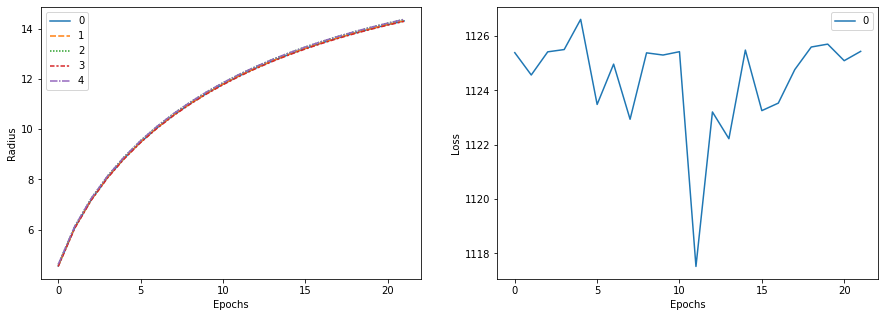

[[44  0  0  0  0  3]
 [ 0 23  0  0  0 26]
 [ 0  0  1  0  0 45]
 [ 1  0  0  1  0 44]
 [ 0  0  0  0 35 15]
 [ 8  2  0  0  0 40]]
50.0
f1_weighted: 0.4682223729015893, f1_macro: 0.46150030183064755, f1_micro: 0.5, f_measure: {'Known': 48.2051, 'Open': 35.8744, 'F1-score': 46.15}
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        47
           1       0.92      0.47      0.62        49
           2       1.00      0.02      0.04        46
           3       1.00      0.02      0.04        46
           4       1.00      0.70      0.82        50
           5       0.23      0.80      0.36        50

    accuracy                           0.50       288
   macro avg       0.83      0.49      0.46       288
weighted avg       0.83      0.50      0.47       288



In [14]:
comment="increase the embedding size"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=4,
                             lr_rate=5, optimizer='adam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=3, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 104ms/step - loss: 1.2459 - accuracy: 0.5186 - precision_1: 0.9662 - recall_1: 0.2450 - val_loss: 1.0478 - val_accuracy: 0.7411 - val_precision_1: 1.0000 - val_recall_1: 0.3884
Epoch 2/14
62/62 [==============================] - 6s 97ms/step - loss: 0.7508 - accuracy: 0.7021 - precision_1: 0.9371 - recall_1: 0.5706 - val_loss: 0.6129 - val_accuracy: 0.7634 - val_precision_1: 0.9937 - val_recall_1: 0.7098
Epoch 3/14
62/62 [==============================] - 6s 95ms/step - loss: 0.4726 - accuracy: 0.7692 - precision_1: 0.92

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.00it/s]


epoch: 1/50, train_loss: 18.151351928710938, F1_train: 0.08871456684227033 F1_val: 0.09757763975155277


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.11it/s]


epoch: 2/50, train_loss: 18.138113021850586, F1_train: 0.13061567624531095 F1_val: 0.15937668463611862


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s]


epoch: 3/50, train_loss: 18.15184211730957, F1_train: 0.16142907873377477 F1_val: 0.22586163836163836


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.21it/s]


epoch: 4/50, train_loss: 18.153200149536133, F1_train: 0.29898464601394537 F1_val: 0.284407412092082


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.22it/s]


epoch: 5/50, train_loss: 18.171104431152344, F1_train: 0.3193646796447205 F1_val: 0.299965798208115


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 6/50, train_loss: 18.120651245117188, F1_train: 0.35246361412990856 F1_val: 0.3003810313511806


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.23it/s]


epoch: 7/50, train_loss: 18.14455223083496, F1_train: 0.38049123448800387 F1_val: 0.3236661347394713


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.22it/s]


epoch: 8/50, train_loss: 18.111858367919922, F1_train: 0.4066804435126452 F1_val: 0.36386865601503754


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.20it/s]


epoch: 9/50, train_loss: 18.151241302490234, F1_train: 0.4324249639964511 F1_val: 0.3914322226065567


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.24it/s]


epoch: 10/50, train_loss: 18.149948120117188, F1_train: 0.4505658814318466 F1_val: 0.4091544881676848


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.22it/s]


epoch: 11/50, train_loss: 18.15192985534668, F1_train: 0.4757267893287854 F1_val: 0.42065945614082256


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.96it/s]


epoch: 12/50, train_loss: 18.024578094482422, F1_train: 0.4977509907326265 F1_val: 0.4242910102637546


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.02it/s]


epoch: 13/50, train_loss: 18.116193771362305, F1_train: 0.5081357866266917 F1_val: 0.4355502705777146


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.21it/s]


epoch: 14/50, train_loss: 18.10032844543457, F1_train: 0.5202113174033527 F1_val: 0.4467304174679419


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.15it/s]


epoch: 15/50, train_loss: 18.152881622314453, F1_train: 0.5287507850921194 F1_val: 0.4393028056993941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.16it/s]


epoch: 16/50, train_loss: 18.116981506347656, F1_train: 0.5419182298676385 F1_val: 0.4523374230370582


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.10it/s]


epoch: 17/50, train_loss: 18.121435165405273, F1_train: 0.553697007859895 F1_val: 0.48795240485752533


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.01it/s]


epoch: 18/50, train_loss: 18.14130401611328, F1_train: 0.5690148997173855 F1_val: 0.4911180820015407


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.23it/s]


epoch: 19/50, train_loss: 18.154699325561523, F1_train: 0.5771509279544255 F1_val: 0.5207405223905692


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.21it/s]


epoch: 20/50, train_loss: 18.156415939331055, F1_train: 0.5862028441251307 F1_val: 0.5104053508575397


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.21it/s]


epoch: 21/50, train_loss: 18.14659309387207, F1_train: 0.5935910917950484 F1_val: 0.494247450348619


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.22it/s]


epoch: 22/50, train_loss: 18.15212059020996, F1_train: 0.6017526724919785 F1_val: 0.5158407755933828


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.20it/s]


epoch: 23/50, train_loss: 18.16817283630371, F1_train: 0.6099545729663821 F1_val: 0.5016406265593086


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.20it/s]


epoch: 24/50, train_loss: 18.173057556152344, F1_train: 0.613172794536517 F1_val: 0.527007411516238


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.12it/s]


epoch: 25/50, train_loss: 18.13289451599121, F1_train: 0.6174493328840263 F1_val: 0.5071397885017391


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.20it/s]


epoch: 26/50, train_loss: 18.17063331604004, F1_train: 0.6226789012789379 F1_val: 0.5300477455797392


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 27/50, train_loss: 18.130525588989258, F1_train: 0.627654070709922 F1_val: 0.5330666357452072


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.30it/s]


epoch: 28/50, train_loss: 18.088838577270508, F1_train: 0.6295366452238346 F1_val: 0.5173835918394188


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.33it/s]


epoch: 29/50, train_loss: 18.115644454956055, F1_train: 0.6370684596732517 F1_val: 0.5140989012258823


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.35it/s]


epoch: 30/50, train_loss: 18.145465850830078, F1_train: 0.6382741716951459 F1_val: 0.524664412929761


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 31/50, train_loss: 18.11695671081543, F1_train: 0.6434691046493017 F1_val: 0.5127829980866102


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 32/50, train_loss: 18.17409324645996, F1_train: 0.64586085764544 F1_val: 0.5219827281886493


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.33it/s]


epoch: 33/50, train_loss: 18.147327423095703, F1_train: 0.6506794764378036 F1_val: 0.5205811348353278


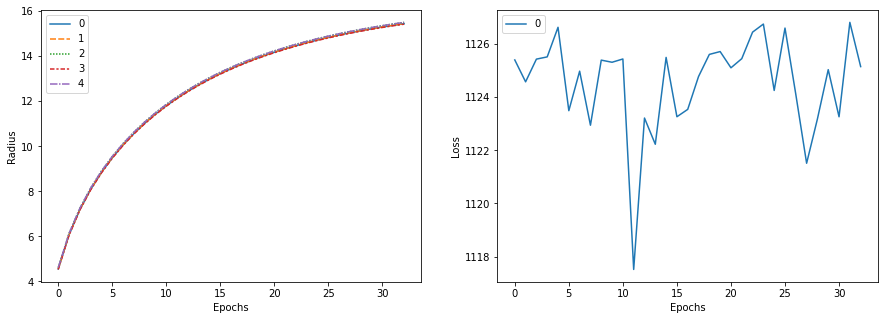

[[47  0  0  0  0  0]
 [ 0 27  0  0  0 22]
 [ 0  0  1  0  0 45]
 [ 1  0  0  2  0 43]
 [ 0  0  0  0 37 13]
 [ 9  2  0  0  0 39]]
53.12
f1_weighted: 0.4969430150797513, f1_macro: 0.490089935320351, f1_micro: 0.53125, f_measure: {'Known': 51.4523, 'Open': 36.7925, 'F1-score': 49.009}
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        47
           1       0.93      0.55      0.69        49
           2       1.00      0.02      0.04        46
           3       1.00      0.04      0.08        46
           4       1.00      0.74      0.85        50
           5       0.24      0.78      0.37        50

    accuracy                           0.53       288
   macro avg       0.83      0.52      0.49       288
weighted avg       0.83      0.53      0.50       288



In [15]:
comment="increase the wait patience"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=4,
                             lr_rate=5, optimizer='adam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 106ms/step - loss: 1.2459 - accuracy: 0.5186 - precision_2: 0.9662 - recall_2: 0.2450 - val_loss: 1.0478 - val_accuracy: 0.7411 - val_precision_2: 1.0000 - val_recall_2: 0.3884
Epoch 2/14
62/62 [==============================] - 6s 102ms/step - loss: 0.7508 - accuracy: 0.7021 - precision_2: 0.9371 - recall_2: 0.5706 - val_loss: 0.6129 - val_accuracy: 0.7634 - val_precision_2: 0.9937 - val_recall_2: 0.7098
Epoch 3/14
62/62 [==============================] - 6s 98ms/step - loss: 0.4726 - accuracy: 0.7692 - precision_2: 0.9

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.00it/s]


epoch: 1/50, train_loss: 18.151351928710938, F1_train: 0.8174106353610844 F1_val: 0.6546556089240964


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.06it/s]


epoch: 2/50, train_loss: 18.138113021850586, F1_train: 0.9342663927398412 F1_val: 0.9577256316942412


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.81it/s]


epoch: 3/50, train_loss: 18.15184211730957, F1_train: 0.9379724061134367 F1_val: 0.9817363437901043


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.52it/s]


epoch: 4/50, train_loss: 18.153200149536133, F1_train: 0.9404426118747164 F1_val: 0.9887142881990171


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.06it/s]


epoch: 5/50, train_loss: 18.171104431152344, F1_train: 0.9437406192511955 F1_val: 0.9909681180164372


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.06it/s]


epoch: 6/50, train_loss: 18.120651245117188, F1_train: 0.9447977662119474 F1_val: 0.9909686455227253


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s]


epoch: 7/50, train_loss: 18.14455223083496, F1_train: 0.9453444829509439 F1_val: 0.9932784911717496


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s]


epoch: 8/50, train_loss: 18.111858367919922, F1_train: 0.9462459369296361 F1_val: 0.9932784911717496


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 9/50, train_loss: 18.151241302490234, F1_train: 0.9464770894219585 F1_val: 0.9977422003284072


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 10/50, train_loss: 18.149948120117188, F1_train: 0.9483575835350756 F1_val: 0.9932753164556962


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 11/50, train_loss: 18.15192985534668, F1_train: 0.9478748069778745 F1_val: 0.9955335537118659


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 12/50, train_loss: 18.024578094482422, F1_train: 0.9488958373561449 F1_val: 0.9955340590073627


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s]


epoch: 13/50, train_loss: 18.116193771362305, F1_train: 0.9491609333151005 F1_val: 0.9955351377280862


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.52it/s]


epoch: 14/50, train_loss: 18.10032844543457, F1_train: 0.9481501235928776 F1_val: 0.9955339828238988


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.40it/s]


epoch: 15/50, train_loss: 18.152881622314453, F1_train: 0.9476636114933725 F1_val: 0.9955351377280862


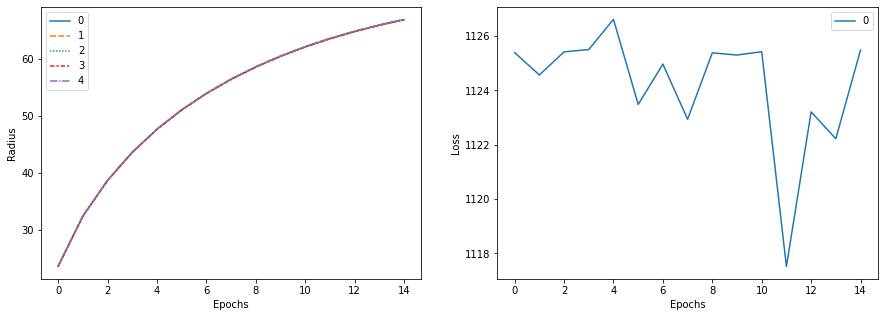

[[47  0  0  0  0  0]
 [ 0 49  0  0  0  0]
 [ 0  0 46  0  0  0]
 [ 1  0  0 45  0  0]
 [ 0  0  0  0 50  0]
 [33 17  0  0  0  0]]
82.29
f1_weighted: 0.7561342091445692, f1_macro: 0.7625933170090778, f1_micro: 0.8229166666666666, f_measure: {'Known': 91.5112, 'Open': 0, 'F1-score': 76.2593}
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        47
           1       0.74      1.00      0.85        49
           2       1.00      1.00      1.00        46
           3       1.00      0.98      0.99        46
           4       1.00      1.00      1.00        50
           5       0.00      0.00      0.00        50

    accuracy                           0.82       288
   macro avg       0.72      0.83      0.76       288
weighted avg       0.71      0.82      0.76       288



In [16]:
comment="changing the optimizer"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=4,
                             lr_rate=5, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 103ms/step - loss: 1.2459 - accuracy: 0.5186 - precision_3: 0.9662 - recall_3: 0.2450 - val_loss: 1.0478 - val_accuracy: 0.7411 - val_precision_3: 1.0000 - val_recall_3: 0.3884
Epoch 2/14
62/62 [==============================] - 6s 99ms/step - loss: 0.7508 - accuracy: 0.7021 - precision_3: 0.9371 - recall_3: 0.5706 - val_loss: 0.6129 - val_accuracy: 0.7634 - val_precision_3: 0.9937 - val_recall_3: 0.7098
Epoch 3/14
62/62 [==============================] - 6s 101ms/step - loss: 0.4726 - accuracy: 0.7692 - precision_3: 0.9

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.96it/s]


epoch: 1/50, train_loss: 18.151351928710938, F1_train: 0.045609531836640876 F1_val: 0.03449006782945736


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.97it/s]


epoch: 2/50, train_loss: 18.138113021850586, F1_train: 0.06489410451191155 F1_val: 0.09024146343319936


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.98it/s]


epoch: 3/50, train_loss: 18.15184211730957, F1_train: 0.08403036764532727 F1_val: 0.10568270165208941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.93it/s]


epoch: 4/50, train_loss: 18.153200149536133, F1_train: 0.09896934842016944 F1_val: 0.13370139679342605


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.94it/s]


epoch: 5/50, train_loss: 18.171104431152344, F1_train: 0.1062524537870032 F1_val: 0.14115896358543417


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.72it/s]


epoch: 6/50, train_loss: 18.120651245117188, F1_train: 0.12241613959078881 F1_val: 0.15145145359731194


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.97it/s]


epoch: 7/50, train_loss: 18.14455223083496, F1_train: 0.12809970461976317 F1_val: 0.16596153846153847


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.99it/s]


epoch: 8/50, train_loss: 18.111858367919922, F1_train: 0.13857721589456223 F1_val: 0.17935878180821416


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 9/50, train_loss: 18.151241302490234, F1_train: 0.1422433840550143 F1_val: 0.16728428978428975


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.13it/s]


epoch: 10/50, train_loss: 18.149948120117188, F1_train: 0.14577498262026584 F1_val: 0.1903594128329298


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.13it/s]


epoch: 11/50, train_loss: 18.15192985534668, F1_train: 0.14997262226207278 F1_val: 0.21446042053184913


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.12it/s]


epoch: 12/50, train_loss: 18.024578094482422, F1_train: 0.15177437557376314 F1_val: 0.21044117046475536


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.79it/s]


epoch: 13/50, train_loss: 18.116193771362305, F1_train: 0.15782074408424757 F1_val: 0.23789671323588793


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.83it/s]


epoch: 14/50, train_loss: 18.10032844543457, F1_train: 0.16170832500595894 F1_val: 0.23098386701551643


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.74it/s]


epoch: 15/50, train_loss: 18.152881622314453, F1_train: 0.16857122782284856 F1_val: 0.20909314823107925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.96it/s]


epoch: 16/50, train_loss: 18.116981506347656, F1_train: 0.27176081165695304 F1_val: 0.23743350723748144


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.00it/s]


epoch: 17/50, train_loss: 18.121435165405273, F1_train: 0.2742996339610282 F1_val: 0.25603406027934333


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.00it/s]


epoch: 18/50, train_loss: 18.14130401611328, F1_train: 0.27846617560869874 F1_val: 0.2549313822751323


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.53it/s]


epoch: 19/50, train_loss: 18.154699325561523, F1_train: 0.2789090018746679 F1_val: 0.2619338233819706


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.92it/s]


epoch: 20/50, train_loss: 18.156415939331055, F1_train: 0.27817916314604163 F1_val: 0.23612645969318904


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.98it/s]


epoch: 21/50, train_loss: 18.14659309387207, F1_train: 0.28039290688065555 F1_val: 0.24560667958221025


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s]


epoch: 22/50, train_loss: 18.15212059020996, F1_train: 0.2805512202336155 F1_val: 0.261351917072256


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s]


epoch: 23/50, train_loss: 18.16817283630371, F1_train: 0.28076898214669666 F1_val: 0.25826197438039544


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.02it/s]


epoch: 24/50, train_loss: 18.173057556152344, F1_train: 0.282804205145253 F1_val: 0.2574588103782183


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.04it/s]


epoch: 25/50, train_loss: 18.13289451599121, F1_train: 0.28275799182621714 F1_val: 0.2649154974489796


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.06it/s]


epoch: 26/50, train_loss: 18.17063331604004, F1_train: 0.2823851891664108 F1_val: 0.26862982709088756


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s]


epoch: 27/50, train_loss: 18.130525588989258, F1_train: 0.28189284604750026 F1_val: 0.25486854204040427


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.95it/s]


epoch: 28/50, train_loss: 18.088838577270508, F1_train: 0.2828879060916825 F1_val: 0.26278588496330435


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.96it/s]


epoch: 29/50, train_loss: 18.115644454956055, F1_train: 0.2838954312563989 F1_val: 0.2576921560201906


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.40it/s]


epoch: 30/50, train_loss: 18.145465850830078, F1_train: 0.2822855426856365 F1_val: 0.25582996286121285


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.01it/s]


epoch: 31/50, train_loss: 18.11695671081543, F1_train: 0.27940488732350915 F1_val: 0.25180605839173614


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 32/50, train_loss: 18.17409324645996, F1_train: 0.28151312725063177 F1_val: 0.256766206482593


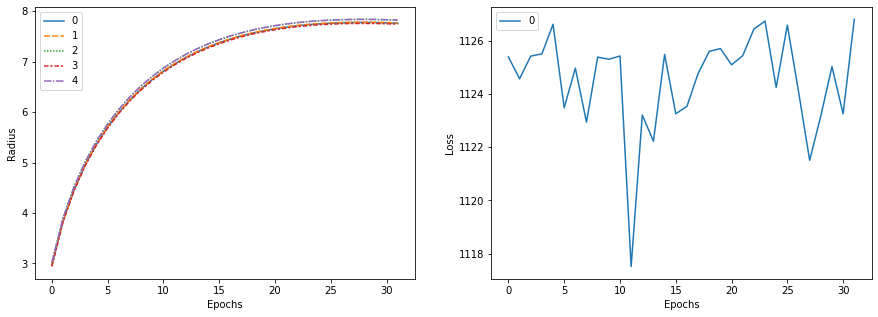

[[18  0  0  0  0 29]
 [ 0  8  0  0  0 41]
 [ 0  0  0  0  0 46]
 [ 1  0  0  0  0 45]
 [ 0  0  0  0 13 37]
 [ 2  0  0  0  0 48]]
30.21
f1_weighted: 0.2621106797125889, f1_macro: 0.25785604268576406, f1_micro: 0.3020833333333333, f_measure: {'Known': 24.4562, 'Open': 32.4324, 'F1-score': 25.7856}
              precision    recall  f1-score   support

           0       0.86      0.38      0.53        47
           1       1.00      0.16      0.28        49
           2       0.00      0.00      0.00        46
           3       0.00      0.00      0.00        46
           4       1.00      0.26      0.41        50
           5       0.20      0.96      0.32        50

    accuracy                           0.30       288
   macro avg       0.51      0.29      0.26       288
weighted avg       0.52      0.30      0.26       288



In [17]:
comment="nadam optimizer with lower LR"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=4,
                             lr_rate=0.5, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 107ms/step - loss: 1.2459 - accuracy: 0.5186 - precision_4: 0.9662 - recall_4: 0.2450 - val_loss: 1.0478 - val_accuracy: 0.7411 - val_precision_4: 1.0000 - val_recall_4: 0.3884
Epoch 2/14
62/62 [==============================] - 6s 100ms/step - loss: 0.7508 - accuracy: 0.7021 - precision_4: 0.9371 - recall_4: 0.5706 - val_loss: 0.6129 - val_accuracy: 0.7634 - val_precision_4: 0.9937 - val_recall_4: 0.7098
Epoch 3/14
62/62 [==============================] - 6s 103ms/step - loss: 0.4726 - accuracy: 0.7692 - precision_4: 0.

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.82it/s]


epoch: 1/50, train_loss: 18.151351928710938, F1_train: 0.045609531836640876 F1_val: 0.03449006782945736


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.91it/s]


epoch: 2/50, train_loss: 18.138113021850586, F1_train: 0.06489410451191155 F1_val: 0.09024146343319936


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.87it/s]


epoch: 3/50, train_loss: 18.15184211730957, F1_train: 0.08403036764532727 F1_val: 0.10568270165208941


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.80it/s]


epoch: 4/50, train_loss: 18.153200149536133, F1_train: 0.09896934842016944 F1_val: 0.13370139679342605


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.63it/s]


epoch: 5/50, train_loss: 18.171104431152344, F1_train: 0.1062524537870032 F1_val: 0.14115896358543417


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.01it/s]


epoch: 6/50, train_loss: 18.120651245117188, F1_train: 0.12241613959078881 F1_val: 0.15145145359731194


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.78it/s]


epoch: 7/50, train_loss: 18.14455223083496, F1_train: 0.12809970461976317 F1_val: 0.16596153846153847


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.89it/s]


epoch: 8/50, train_loss: 18.111858367919922, F1_train: 0.13857721589456223 F1_val: 0.17935878180821416


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.58it/s]


epoch: 9/50, train_loss: 18.151241302490234, F1_train: 0.1422433840550143 F1_val: 0.16728428978428975


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.64it/s]


epoch: 10/50, train_loss: 18.149948120117188, F1_train: 0.14577498262026584 F1_val: 0.1903594128329298


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.96it/s]


epoch: 11/50, train_loss: 18.15192985534668, F1_train: 0.14997262226207278 F1_val: 0.21446042053184913


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.97it/s]


epoch: 12/50, train_loss: 18.024578094482422, F1_train: 0.15177437557376314 F1_val: 0.21044117046475536


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.37it/s]


epoch: 13/50, train_loss: 18.116193771362305, F1_train: 0.15782074408424757 F1_val: 0.23789671323588793


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.10it/s]


epoch: 14/50, train_loss: 18.10032844543457, F1_train: 0.16170832500595894 F1_val: 0.23098386701551643


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.35it/s]


epoch: 15/50, train_loss: 18.152881622314453, F1_train: 0.16857122782284856 F1_val: 0.20909314823107925


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.70it/s]


epoch: 16/50, train_loss: 18.116981506347656, F1_train: 0.27176081165695304 F1_val: 0.23743350723748144


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.96it/s]


epoch: 17/50, train_loss: 18.121435165405273, F1_train: 0.2742996339610282 F1_val: 0.25603406027934333


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.04it/s]


epoch: 18/50, train_loss: 18.14130401611328, F1_train: 0.27846617560869874 F1_val: 0.2549313822751323


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 19/50, train_loss: 18.154699325561523, F1_train: 0.2789090018746679 F1_val: 0.2619338233819706


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 20/50, train_loss: 18.156415939331055, F1_train: 0.27817916314604163 F1_val: 0.23612645969318904


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.04it/s]


epoch: 21/50, train_loss: 18.14659309387207, F1_train: 0.28039290688065555 F1_val: 0.24560667958221025


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.93it/s]


epoch: 22/50, train_loss: 18.15212059020996, F1_train: 0.2805512202336155 F1_val: 0.261351917072256


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.61it/s]


epoch: 23/50, train_loss: 18.16817283630371, F1_train: 0.28076898214669666 F1_val: 0.25826197438039544


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.20it/s]


epoch: 24/50, train_loss: 18.173057556152344, F1_train: 0.282804205145253 F1_val: 0.2574588103782183


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.60it/s]


epoch: 25/50, train_loss: 18.13289451599121, F1_train: 0.28275799182621714 F1_val: 0.2649154974489796


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.00it/s]


epoch: 26/50, train_loss: 18.17063331604004, F1_train: 0.2823851891664108 F1_val: 0.26862982709088756


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.80it/s]


epoch: 27/50, train_loss: 18.130525588989258, F1_train: 0.28189284604750026 F1_val: 0.25486854204040427


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.88it/s]


epoch: 28/50, train_loss: 18.088838577270508, F1_train: 0.2828879060916825 F1_val: 0.26278588496330435


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.80it/s]


epoch: 29/50, train_loss: 18.115644454956055, F1_train: 0.2838954312563989 F1_val: 0.2576921560201906


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.22it/s]


epoch: 30/50, train_loss: 18.145465850830078, F1_train: 0.2822855426856365 F1_val: 0.25582996286121285


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.78it/s]


epoch: 31/50, train_loss: 18.11695671081543, F1_train: 0.27940488732350915 F1_val: 0.25180605839173614


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.81it/s]


epoch: 32/50, train_loss: 18.17409324645996, F1_train: 0.28151312725063177 F1_val: 0.256766206482593


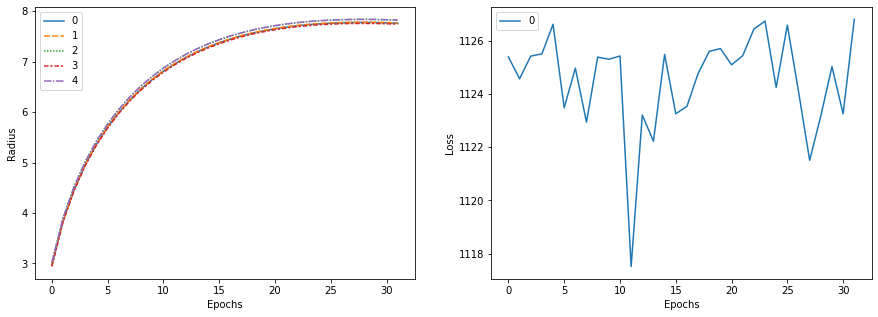

[[18  0  0  0  0 29]
 [ 0  8  0  0  0 41]
 [ 0  0  0  0  0 46]
 [ 1  0  0  0  0 45]
 [ 0  0  0  0 13 37]
 [ 2  0  0  0  0 48]]
30.21
f1_weighted: 0.2621106797125889, f1_macro: 0.25785604268576406, f1_micro: 0.3020833333333333, f_measure: {'Known': 24.4562, 'Open': 32.4324, 'F1-score': 25.7856}
              precision    recall  f1-score   support

           0       0.86      0.38      0.53        47
           1       1.00      0.16      0.28        49
           2       0.00      0.00      0.00        46
           3       0.00      0.00      0.00        46
           4       1.00      0.26      0.41        50
           5       0.20      0.96      0.32        50

    accuracy                           0.30       288
   macro avg       0.51      0.29      0.26       288
weighted avg       0.52      0.30      0.26       288



In [18]:
comment="nadam optimizer with lower LR=1"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=4,
                             lr_rate=0.5, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 103ms/step - loss: 1.2459 - accuracy: 0.5186 - precision_5: 0.9662 - recall_5: 0.2450 - val_loss: 1.0478 - val_accuracy: 0.7411 - val_precision_5: 1.0000 - val_recall_5: 0.3884
Epoch 2/14
62/62 [==============================] - 6s 100ms/step - loss: 0.7508 - accuracy: 0.7021 - precision_5: 0.9371 - recall_5: 0.5706 - val_loss: 0.6129 - val_accuracy: 0.7634 - val_precision_5: 0.9937 - val_recall_5: 0.7098
Epoch 3/14
62/62 [==============================] - 6s 98ms/step - loss: 0.4726 - accuracy: 0.7692 - precision_5: 0.9

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 1/50, train_loss: 18.151351928710938, F1_train: 0.3678139165876945 F1_val: 0.31595050300622785


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.04it/s]


epoch: 2/50, train_loss: 18.138113021850586, F1_train: 0.5520255268580848 F1_val: 0.46528058582304344


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 3/50, train_loss: 18.15184211730957, F1_train: 0.6569693509824124 F1_val: 0.5310989145361853


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 4/50, train_loss: 18.153200149536133, F1_train: 0.715188141313165 F1_val: 0.5664871676087381


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 5/50, train_loss: 18.171104431152344, F1_train: 0.7484991908476373 F1_val: 0.5523616497881204


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.10it/s]


epoch: 6/50, train_loss: 18.120651245117188, F1_train: 0.7732290255128463 F1_val: 0.5691665428170606


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.10it/s]


epoch: 7/50, train_loss: 18.14455223083496, F1_train: 0.7918963156569148 F1_val: 0.626253098441085


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.11it/s]


epoch: 8/50, train_loss: 18.111858367919922, F1_train: 0.8074052048695315 F1_val: 0.65850952503645


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.12it/s]


epoch: 9/50, train_loss: 18.151241302490234, F1_train: 0.8234925107380048 F1_val: 0.669548516743259


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.13it/s]


epoch: 10/50, train_loss: 18.149948120117188, F1_train: 0.8432518741858902 F1_val: 0.7278832177651138


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s]


epoch: 11/50, train_loss: 18.15192985534668, F1_train: 0.8567298071869044 F1_val: 0.730180725399099


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.06it/s]


epoch: 12/50, train_loss: 18.024578094482422, F1_train: 0.8690422016991352 F1_val: 0.7830984527957525


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 13/50, train_loss: 18.116193771362305, F1_train: 0.8802431450832033 F1_val: 0.8116208467911538


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.06it/s]


epoch: 14/50, train_loss: 18.10032844543457, F1_train: 0.8893880606039049 F1_val: 0.8056186360717852


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 15/50, train_loss: 18.152881622314453, F1_train: 0.8968526191924816 F1_val: 0.8351962046179706


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.95it/s]


epoch: 16/50, train_loss: 18.116981506347656, F1_train: 0.9006884149830785 F1_val: 0.8592178062976049


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 17/50, train_loss: 18.121435165405273, F1_train: 0.9031058580430655 F1_val: 0.8768203769802235


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.04it/s]


epoch: 18/50, train_loss: 18.14130401611328, F1_train: 0.9069553301683079 F1_val: 0.880517965899517


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 19/50, train_loss: 18.154699325561523, F1_train: 0.9086676957435792 F1_val: 0.880709756516555


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s]


epoch: 20/50, train_loss: 18.156415939331055, F1_train: 0.9120541728265734 F1_val: 0.8732208792607951


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.99it/s]


epoch: 21/50, train_loss: 18.14659309387207, F1_train: 0.9147240705035109 F1_val: 0.8915034863025743


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.03it/s]


epoch: 22/50, train_loss: 18.15212059020996, F1_train: 0.9166147222494949 F1_val: 0.8926501672373828


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.00it/s]


epoch: 23/50, train_loss: 18.16817283630371, F1_train: 0.916109037178203 F1_val: 0.8913587632754634


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s]


epoch: 24/50, train_loss: 18.173057556152344, F1_train: 0.916162486863523 F1_val: 0.9034692528950671


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.04it/s]


epoch: 25/50, train_loss: 18.13289451599121, F1_train: 0.9170813156730706 F1_val: 0.8928557875960564


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.11it/s]


epoch: 26/50, train_loss: 18.17063331604004, F1_train: 0.9161152455823457 F1_val: 0.8926369268187601


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 27/50, train_loss: 18.130525588989258, F1_train: 0.9166584940313868 F1_val: 0.8932378652932805


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 28/50, train_loss: 18.088838577270508, F1_train: 0.9167660769926393 F1_val: 0.8898253991400971


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 29/50, train_loss: 18.115644454956055, F1_train: 0.9180503744555715 F1_val: 0.8955340144332491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.19it/s]


epoch: 30/50, train_loss: 18.145465850830078, F1_train: 0.9170983213950135 F1_val: 0.905308550249368


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 31/50, train_loss: 18.11695671081543, F1_train: 0.9165073831840449 F1_val: 0.8940987135634193


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 32/50, train_loss: 18.17409324645996, F1_train: 0.9164898162204322 F1_val: 0.8906989228870498


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.07it/s]


epoch: 33/50, train_loss: 18.147327423095703, F1_train: 0.9171356158213445 F1_val: 0.9049257495310501


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.40it/s]


epoch: 34/50, train_loss: 18.155296325683594, F1_train: 0.9161286974053727 F1_val: 0.8993768104759484


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.23it/s]


epoch: 35/50, train_loss: 18.15797233581543, F1_train: 0.9163767570957442 F1_val: 0.8926894748409959


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.08it/s]


epoch: 36/50, train_loss: 18.18946075439453, F1_train: 0.9164541299800164 F1_val: 0.9001467171089644


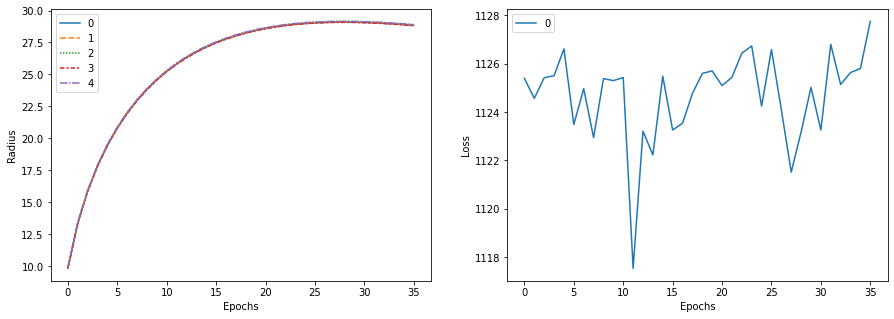

[[47  0  0  0  0  0]
 [ 0 44  0  0  0  5]
 [ 0  0 36  0  0 10]
 [ 1  0  0 34  0 11]
 [ 0  0  0  0 48  2]
 [15 13  0  0  0 22]]
80.21
f1_weighted: 0.8031691575896839, f1_macro: 0.8053957918355396, f1_micro: 0.8020833333333334, f_measure: {'Known': 87.8475, 'Open': 44.0, 'F1-score': 80.5396}
              precision    recall  f1-score   support

           0       0.75      1.00      0.85        47
           1       0.77      0.90      0.83        49
           2       1.00      0.78      0.88        46
           3       1.00      0.74      0.85        46
           4       1.00      0.96      0.98        50
           5       0.44      0.44      0.44        50

    accuracy                           0.80       288
   macro avg       0.83      0.80      0.81       288
weighted avg       0.82      0.80      0.80       288



In [19]:
comment="nadam optimizer with lower LR=2"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=4,
                             lr_rate=2, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 100ms/step - loss: 1.1837 - accuracy: 0.5585 - precision_6: 0.9676 - recall_6: 0.2858 - val_loss: 1.0390 - val_accuracy: 0.6250 - val_precision_6: 1.0000 - val_recall_6: 0.3839
Epoch 2/14
62/62 [==============================] - 6s 101ms/step - loss: 0.6789 - accuracy: 0.7505 - precision_6: 0.9445 - recall_6: 0.6008 - val_loss: 0.5300 - val_accuracy: 0.8527 - val_precision_6: 0.9563 - val_recall_6: 0.7812
Epoch 3/14
62/62 [==============================] - 6s 96ms/step - loss: 0.4606 - accuracy: 0.8735 - precision_6: 0.9

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.80it/s]


epoch: 1/50, train_loss: 15.401331901550293, F1_train: 0.5670769657912151 F1_val: 0.38378803237635833


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.25it/s]


epoch: 2/50, train_loss: 15.378965377807617, F1_train: 0.6811872947056258 F1_val: 0.513938053291492


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.15it/s]


epoch: 3/50, train_loss: 15.374783515930176, F1_train: 0.7155560865938567 F1_val: 0.5951806440015098


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  6.20it/s]


epoch: 4/50, train_loss: 15.373117446899414, F1_train: 0.7421545116184292 F1_val: 0.6617546419629753


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.32it/s]


epoch: 5/50, train_loss: 15.411981582641602, F1_train: 0.7687872107020708 F1_val: 0.7104710095693496


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.24it/s]


epoch: 6/50, train_loss: 15.366006851196289, F1_train: 0.7880662474031781 F1_val: 0.7379668617728712


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:10<00:00,  5.98it/s]


epoch: 7/50, train_loss: 15.368725776672363, F1_train: 0.8076298927192748 F1_val: 0.7730650192769416


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.66it/s]


epoch: 8/50, train_loss: 15.362293243408203, F1_train: 0.8283090824518694 F1_val: 0.8110114832010655


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.77it/s]


epoch: 9/50, train_loss: 15.384124755859375, F1_train: 0.8445650505365812 F1_val: 0.8587975911457028


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 10/50, train_loss: 15.370051383972168, F1_train: 0.8629159195453958 F1_val: 0.8731684788394152


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s]


epoch: 11/50, train_loss: 15.4132719039917, F1_train: 0.8791265073889696 F1_val: 0.9199757151569468


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.23it/s]


epoch: 12/50, train_loss: 15.261612892150879, F1_train: 0.8969073332899724 F1_val: 0.9236912886587036


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.23it/s]


epoch: 13/50, train_loss: 15.36155891418457, F1_train: 0.9079187552592771 F1_val: 0.9429304821483845


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s]


epoch: 14/50, train_loss: 15.333009719848633, F1_train: 0.9148541437025186 F1_val: 0.9429495355834642


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.22it/s]


epoch: 15/50, train_loss: 15.40660285949707, F1_train: 0.9204661142459724 F1_val: 0.9428981382500489


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.25it/s]


epoch: 16/50, train_loss: 15.347530364990234, F1_train: 0.9250063607700418 F1_val: 0.9513153974190366


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.30it/s]


epoch: 17/50, train_loss: 15.367637634277344, F1_train: 0.9287923173950601 F1_val: 0.9563741418877482


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.31it/s]


epoch: 18/50, train_loss: 15.36622428894043, F1_train: 0.9304016633550141 F1_val: 0.9562425777903452


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.25it/s]


epoch: 19/50, train_loss: 15.418876647949219, F1_train: 0.9310095655915205 F1_val: 0.9535792981341119


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.35it/s]


epoch: 20/50, train_loss: 15.400623321533203, F1_train: 0.9316469016804814 F1_val: 0.9592224058185196


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 21/50, train_loss: 15.365967750549316, F1_train: 0.9315909930999736 F1_val: 0.9540613888587688


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.30it/s]


epoch: 22/50, train_loss: 15.392633438110352, F1_train: 0.9337984441225499 F1_val: 0.9566053026259962


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 23/50, train_loss: 15.398951530456543, F1_train: 0.9340771565388029 F1_val: 0.9565372350154012


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 24/50, train_loss: 15.418896675109863, F1_train: 0.9338253341943885 F1_val: 0.956585056647857


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.30it/s]


epoch: 25/50, train_loss: 15.373104095458984, F1_train: 0.9340307852369159 F1_val: 0.9566331475679528


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.05it/s]


epoch: 26/50, train_loss: 15.444339752197266, F1_train: 0.9346838043414831 F1_val: 0.9568402556764021


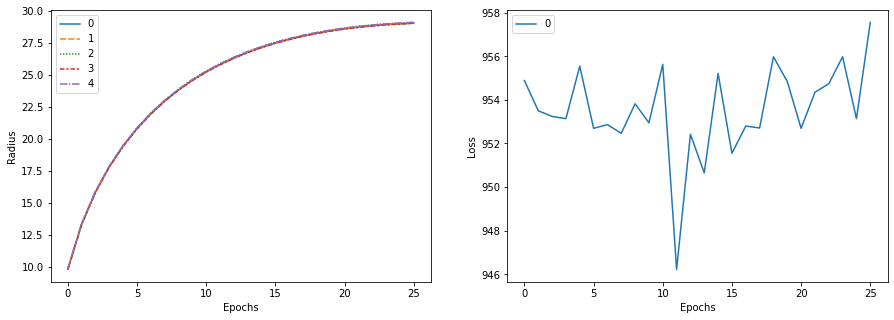

[[46  0  0  0  0  1]
 [ 0 49  0  0  0  0]
 [ 0  0 42  0  0  4]
 [ 0  0  0 33  0 13]
 [ 0  0  0  0 46  4]
 [ 0 27  0  0  0 23]]
82.99
f1_weighted: 0.8311711364385295, f1_macro: 0.834296610666203, f1_micro: 0.8298611111111112, f_measure: {'Known': 90.4314, 'Open': 48.4211, 'F1-score': 83.4297}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        47
           1       0.64      1.00      0.78        49
           2       1.00      0.91      0.95        46
           3       1.00      0.72      0.84        46
           4       1.00      0.92      0.96        50
           5       0.51      0.46      0.48        50

    accuracy                           0.83       288
   macro avg       0.86      0.83      0.83       288
weighted avg       0.85      0.83      0.83       288



In [20]:
comment="nadam optimizer with lower LR=2 and embeds-ze=2"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=2,
                             lr_rate=2, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 97ms/step - loss: 1.1837 - accuracy: 0.5585 - precision_7: 0.9676 - recall_7: 0.2858 - val_loss: 1.0390 - val_accuracy: 0.6250 - val_precision_7: 1.0000 - val_recall_7: 0.3839
Epoch 2/14
62/62 [==============================] - 6s 94ms/step - loss: 0.6789 - accuracy: 0.7505 - precision_7: 0.9445 - recall_7: 0.6008 - val_loss: 0.5300 - val_accuracy: 0.8527 - val_precision_7: 0.9563 - val_recall_7: 0.7812
Epoch 3/14
62/62 [==============================] - 6s 94ms/step - loss: 0.4606 - accuracy: 0.8735 - precision_7: 0.942

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 1/50, train_loss: 15.401331901550293, F1_train: 0.47328232592935915 F1_val: 0.26759649511978706


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 2/50, train_loss: 15.378965377807617, F1_train: 0.5809948618991142 F1_val: 0.4040577973336233


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.35it/s]


epoch: 3/50, train_loss: 15.374783515930176, F1_train: 0.648726036885542 F1_val: 0.4866280730438894


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.34it/s]


epoch: 4/50, train_loss: 15.373117446899414, F1_train: 0.6855866905105962 F1_val: 0.5199657263765517


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.43it/s]


epoch: 5/50, train_loss: 15.411981582641602, F1_train: 0.7037246904237083 F1_val: 0.564216230398651


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.42it/s]


epoch: 6/50, train_loss: 15.366006851196289, F1_train: 0.7173083413109306 F1_val: 0.6053961505880096


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.39it/s]


epoch: 7/50, train_loss: 15.368725776672363, F1_train: 0.7301973455397116 F1_val: 0.6316937375915931


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.38it/s]


epoch: 8/50, train_loss: 15.362293243408203, F1_train: 0.738541304306394 F1_val: 0.6416829528872212


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.42it/s]


epoch: 9/50, train_loss: 15.384124755859375, F1_train: 0.7459015617939798 F1_val: 0.6641695192984309


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.43it/s]


epoch: 10/50, train_loss: 15.370051383972168, F1_train: 0.7556406789933477 F1_val: 0.6818967350284474


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.41it/s]


epoch: 11/50, train_loss: 15.4132719039917, F1_train: 0.7622319393764275 F1_val: 0.7065886563602509


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.43it/s]


epoch: 12/50, train_loss: 15.261612892150879, F1_train: 0.7696018175002831 F1_val: 0.7282346144077042


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.30it/s]


epoch: 13/50, train_loss: 15.36155891418457, F1_train: 0.7734629328992004 F1_val: 0.7333941224491903


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.41it/s]


epoch: 14/50, train_loss: 15.333009719848633, F1_train: 0.7780164995940969 F1_val: 0.7330722164293172


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.41it/s]


epoch: 15/50, train_loss: 15.40660285949707, F1_train: 0.7807482129331634 F1_val: 0.7249447278911564


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.42it/s]


epoch: 16/50, train_loss: 15.347530364990234, F1_train: 0.787995718539313 F1_val: 0.7296228107099889


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.42it/s]


epoch: 17/50, train_loss: 15.367637634277344, F1_train: 0.7896207541726572 F1_val: 0.7594143135514354


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.45it/s]


epoch: 18/50, train_loss: 15.36622428894043, F1_train: 0.79482827909578 F1_val: 0.7612750184517016


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.40it/s]


epoch: 19/50, train_loss: 15.418876647949219, F1_train: 0.7979892661890634 F1_val: 0.7673668690819847


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.44it/s]


epoch: 20/50, train_loss: 15.400623321533203, F1_train: 0.8009743208432544 F1_val: 0.7573899416730027


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.31it/s]


epoch: 21/50, train_loss: 15.365967750549316, F1_train: 0.8021544956271071 F1_val: 0.7528002969623466


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.19it/s]


epoch: 22/50, train_loss: 15.392633438110352, F1_train: 0.8060308799218765 F1_val: 0.7744847261340218


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.19it/s]


epoch: 23/50, train_loss: 15.398951530456543, F1_train: 0.8065021711999346 F1_val: 0.7564332925121616


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.19it/s]


epoch: 24/50, train_loss: 15.418896675109863, F1_train: 0.8066243749999826 F1_val: 0.7634164569105227


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.44it/s]


epoch: 25/50, train_loss: 15.373104095458984, F1_train: 0.8071225963833367 F1_val: 0.7613081025397984


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.47it/s]


epoch: 26/50, train_loss: 15.444339752197266, F1_train: 0.8086059115750813 F1_val: 0.7636104876066873


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.48it/s]


epoch: 27/50, train_loss: 15.41650676727295, F1_train: 0.8070064865734212 F1_val: 0.7779954002877746


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.49it/s]


epoch: 28/50, train_loss: 15.332464218139648, F1_train: 0.808260348481855 F1_val: 0.759776030695571


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.47it/s]


epoch: 29/50, train_loss: 15.377071380615234, F1_train: 0.8082569298325829 F1_val: 0.7644096922106092


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.46it/s]


epoch: 30/50, train_loss: 15.369736671447754, F1_train: 0.8083844771924044 F1_val: 0.7612038799529746


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.49it/s]


epoch: 31/50, train_loss: 15.349509239196777, F1_train: 0.8076650705247583 F1_val: 0.7536959874634664


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.50it/s]


epoch: 32/50, train_loss: 15.413382530212402, F1_train: 0.807749876745609 F1_val: 0.7780983307657822


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.10it/s]


epoch: 33/50, train_loss: 15.391674041748047, F1_train: 0.8081773834332899 F1_val: 0.7753243844102958


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.50it/s]


epoch: 34/50, train_loss: 15.37376880645752, F1_train: 0.8054600010450114 F1_val: 0.7746462972336593


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.51it/s]


epoch: 35/50, train_loss: 15.377516746520996, F1_train: 0.8070879129162606 F1_val: 0.7635519968268694


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.53it/s]


epoch: 36/50, train_loss: 15.403599739074707, F1_train: 0.806205662266341 F1_val: 0.7703615380751457


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.50it/s]


epoch: 37/50, train_loss: 15.438752174377441, F1_train: 0.8046922235391618 F1_val: 0.760564379597993


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.51it/s]


epoch: 38/50, train_loss: 15.398746490478516, F1_train: 0.803458462048963 F1_val: 0.7620947781992023


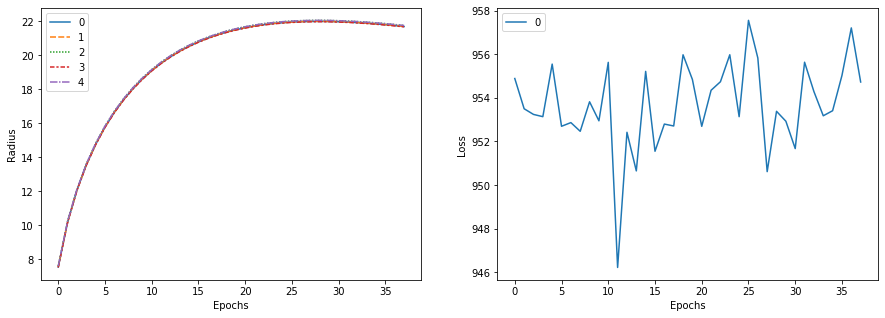

[[41  0  0  0  0  6]
 [ 0 49  0  0  0  0]
 [ 0  0 20  0  0 26]
 [ 0  0  0 11  0 35]
 [ 0  0  0  0 46  4]
 [ 0 11  0  0  0 39]]
71.53
f1_weighted: 0.7144977115534064, f1_macro: 0.7114599337166938, f1_micro: 0.7152777777777778, f_measure: {'Known': 75.6252, 'Open': 48.75, 'F1-score': 71.146}
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        47
           1       0.82      1.00      0.90        49
           2       1.00      0.43      0.61        46
           3       1.00      0.24      0.39        46
           4       1.00      0.92      0.96        50
           5       0.35      0.78      0.49        50

    accuracy                           0.72       288
   macro avg       0.86      0.71      0.71       288
weighted avg       0.86      0.72      0.71       288



In [21]:
comment="lowering the LR a bit nadam optimizer with lower  and embeds-ze=2"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=2,
                             lr_rate=1.5 , optimizer='nadam',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 104ms/step - loss: 1.1837 - accuracy: 0.5585 - precision_9: 0.9676 - recall_9: 0.2858 - val_loss: 1.0390 - val_accuracy: 0.6250 - val_precision_9: 1.0000 - val_recall_9: 0.3839
Epoch 2/14
62/62 [==============================] - 6s 98ms/step - loss: 0.6789 - accuracy: 0.7505 - precision_9: 0.9445 - recall_9: 0.6008 - val_loss: 0.5300 - val_accuracy: 0.8527 - val_precision_9: 0.9563 - val_recall_9: 0.7812
Epoch 3/14
62/62 [==============================] - 6s 98ms/step - loss: 0.4606 - accuracy: 0.8735 - precision_9: 0.94

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  6.95it/s]


epoch: 1/50, train_loss: 15.401331901550293, F1_train: 0.4538441396914607 F1_val: 0.2284631334417825


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.10it/s]


epoch: 2/50, train_loss: 15.378965377807617, F1_train: 0.4549482507990807 F1_val: 0.21795376121463078


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.12it/s]


epoch: 3/50, train_loss: 15.374783515930176, F1_train: 0.45315297967422785 F1_val: 0.23558415763845103


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 4/50, train_loss: 15.373117446899414, F1_train: 0.45437296203453365 F1_val: 0.2332605720153674


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.18it/s]


epoch: 5/50, train_loss: 15.411981582641602, F1_train: 0.4551342966894515 F1_val: 0.23362959624595267


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.17it/s]


epoch: 6/50, train_loss: 15.366006851196289, F1_train: 0.4540920989606582 F1_val: 0.2250317495497017


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.13it/s]


epoch: 7/50, train_loss: 15.368725776672363, F1_train: 0.45368913580723824 F1_val: 0.22931644110104626


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.87it/s]


epoch: 8/50, train_loss: 15.362293243408203, F1_train: 0.45491157478859656 F1_val: 0.20897485666507407


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.24it/s]


epoch: 9/50, train_loss: 15.384124755859375, F1_train: 0.4549950308872586 F1_val: 0.23008071403397276


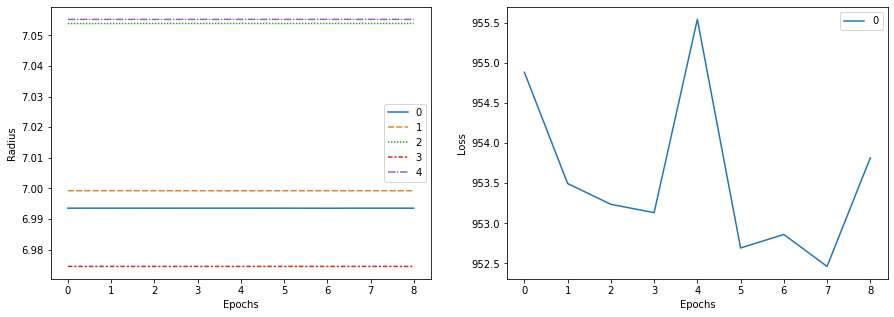

[[14  0  0  0  0 33]
 [ 0 36  0  0  0 13]
 [ 0  0  0  0  0 46]
 [ 0  0  0  2  0 44]
 [ 0  0  0  0 10 40]
 [ 0  1  0  0  0 49]]
38.54
f1_weighted: 0.3504000282081201, f1_macro: 0.34487599979975125, f1_micro: 0.38541666666666663, f_measure: {'Known': 34.2578, 'Open': 35.6364, 'F1-score': 34.4876}
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        47
           1       0.97      0.73      0.84        49
           2       0.00      0.00      0.00        46
           3       1.00      0.04      0.08        46
           4       1.00      0.20      0.33        50
           5       0.22      0.98      0.36        50

    accuracy                           0.39       288
   macro avg       0.70      0.38      0.34       288
weighted avg       0.70      0.39      0.35       288



In [23]:
comment="rmsprop optimizer with  LR=2 and embeds-ze=2"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=2,
                             lr_rate=2, optimizer='rmsprop',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 400
val_0:, 50
test_0:, 50
train_1:, 400
val_1:, 50
test_1:, 50
train_2:, 400
val_2:, 50
test_2:, 50
train_3:, 400
val_3:, 50
test_3:, 50
train_4:, 400
val_4:, 50
test_4:, 50
class 5 is added as ukc
ukc_5:, 50
vocab_size: 50
Epoch 1/14
62/62 [==============================] - 7s 100ms/step - loss: 1.1837 - accuracy: 0.5585 - precision_10: 0.9676 - recall_10: 0.2858 - val_loss: 1.0390 - val_accuracy: 0.6250 - val_precision_10: 1.0000 - val_recall_10: 0.3839
Epoch 2/14
62/62 [==============================] - 6s 95ms/step - loss: 0.6789 - accuracy: 0.7505 - precision_10: 0.9445 - recall_10: 0.6008 - val_loss: 0.5300 - val_accuracy: 0.8527 - val_precision_10: 0.9563 - val_recall_10: 0.7812
Epoch 3/14
62/62 [==============================] - 6s 98ms/step - loss: 0.4606 - accuracy: 0.8735 - precision

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.02it/s]


epoch: 1/50, train_loss: 15.401331901550293, F1_train: 0.11183119205224276 F1_val: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.14it/s]


epoch: 2/50, train_loss: 15.378965377807617, F1_train: 0.11241219883543592 F1_val: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.20it/s]


epoch: 3/50, train_loss: 15.374783515930176, F1_train: 0.11373643628000234 F1_val: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.23it/s]


epoch: 4/50, train_loss: 15.373117446899414, F1_train: 0.11319947833369569 F1_val: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.17it/s]


epoch: 5/50, train_loss: 15.411981582641602, F1_train: 0.1153285633133469 F1_val: 0.0


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:08<00:00,  7.25it/s]


epoch: 6/50, train_loss: 15.366006851196289, F1_train: 0.11068967286637937 F1_val: 0.0


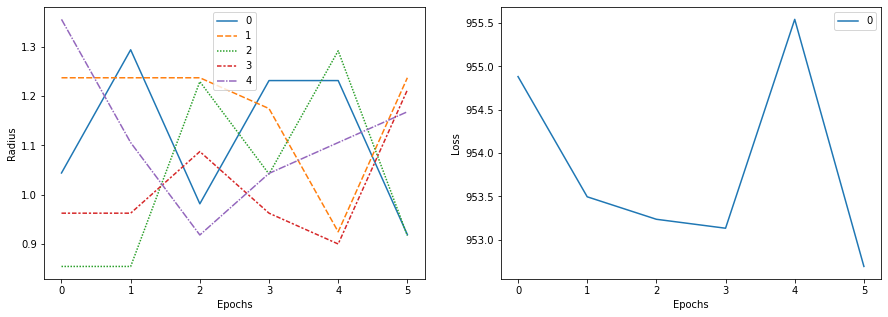

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [24]:
comment="sgd optimizer with  LR=2 and embeds-ze=2"
test_data, oset = oset_train(ablation=500,designated_ukc_cls=5,num_classes=5,embedding_size=2,
                             lr_rate=2, optimizer='sgd',
pretrain_epochs=14,octrain_epochs=50, wait_patient=6, comment=comment)

In [7]:
import os
from win32com import client
cmd = os.system("start /wait cmd /c {command}")
try:
    xl = client.Dispatch("Excel.Application")
    wb = xl.Workbooks.Open(Filename='tracker.xlsx')
    # Do stuff
    os_close = os.close()
    try:
        os_close
        wb.close(SaveChanges=0)
    except NameError:
        print('NameError',NameError)

except Exception as e:
    print('e',e)

e (-2147352567, 'Exception occurred.', (0, 'Microsoft Excel', "Sorry, we couldn't find tracker.xlsx. Is it possible it was moved, renamed or deleted?", 'xlmain11.chm', 0, -2146827284), None)
